Don't kill this notebook plz

In [ ]:
import time
import torch
while True:
    a = torch.zeros([10, 10, 10], dtype = torch.float32, device = 'cuda:3', requires_grad = False)
    b = a * a
    print(b[0, 0, 0])
    time.sleep(300)

tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)

In [2]:
import defdevice
defdevice.force_device('cuda:3')
import metrics
import nns
import immaskdataset
import importlib
import imcapdataset
import embdataset
import embedders
import losses
import imageops
import misc
import segmodel

image_ds = embdataset.RAMLoadDataset('COCOM2F_ALL_d8', load_amount = 1000000, norm = True)
text_ds = embdataset.RAMLoadDataset('COCOCLIP_ALL', load_amount = 1000000)

model = nns.Linear(text_ds.embedding_shape, image_ds.embedding_shape)

def_device = 'cuda:3'

image_ds.reset()
text_ds.reset()

import torch
import torch.nn.functional

batch_count = 100000
batch_size = 128
optim = torch.optim.Adam(model.parameters, lr = 0.003)

image_noise = 0.07 / 10
text_noise = 0.15

for batch_idx in range(batch_count):
    ibatch = image_ds.get_batch(batch_size).to(def_device)
    tbatch = text_ds.get_batch(batch_size).to(def_device)
    
    ibatch = ibatch + torch.rand_like(ibatch) * image_noise
    tbatch = tbatch + torch.rand_like(tbatch) * text_noise
    
    tbatch = model.forward(tbatch)
    
    neg_ibatch, neg_tbatch = losses.sample_negatives(ibatch, tbatch, batch_size)
    
    prods = losses.get_products(ibatch, tbatch)
    probs = torch.sigmoid(prods)
    
    neg_prods = losses.get_products(neg_ibatch, neg_tbatch)
    neg_probs = torch.sigmoid(neg_prods)
    
    loss_positive = losses.max_pressure_loss(probs, 1.0)
    loss_negative = losses.max_pressure_loss(neg_probs, 0.0)
    
    loss = (loss_positive + loss_negative) / 2
    
    loss.backward()
    optim.step()
    optim.zero_grad()
    
    if batch_idx % 1000 == 0:
        print(batch_idx, loss_positive, loss_negative)

In [166]:
colorsl = [[255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0], [255, 0, 255], [0, 255, 255], [0, 0, 0]]
colors = np.array(colorsl)
colorsl = [[c / 255 for c in color] for color in colorsl]

def array_to_rgb(array):
    # Get the shape of the input array (n, y, x)
    n, y, x = array.shape
    
    # Find the index of the maximum value along the first axis (n)
    max_indices = np.argmax(array, axis=0)
    
    # Create an empty RGB image with shape (y, x, 3)
    rgb_image = np.zeros((y, x, 3), dtype=np.uint8)
    
    # Populate the RGB image with colors
    for i in range(n):
        mask = max_indices == i
        rgb_image[mask] = colors[i]
        
    return rgb_image

In [229]:
model.save('CSModelCheckpoint')

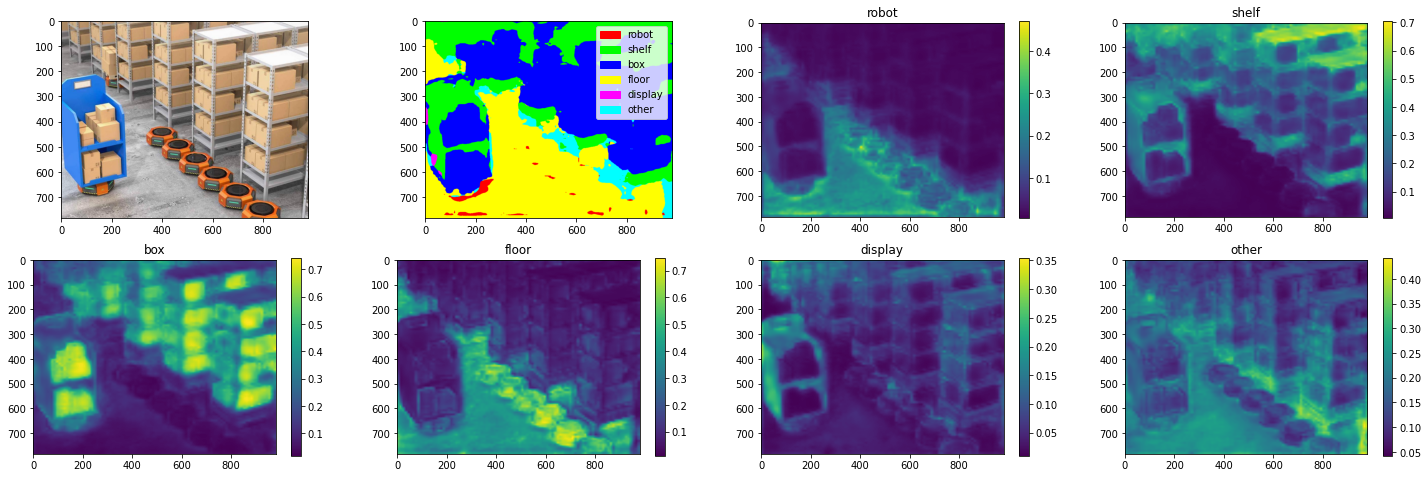

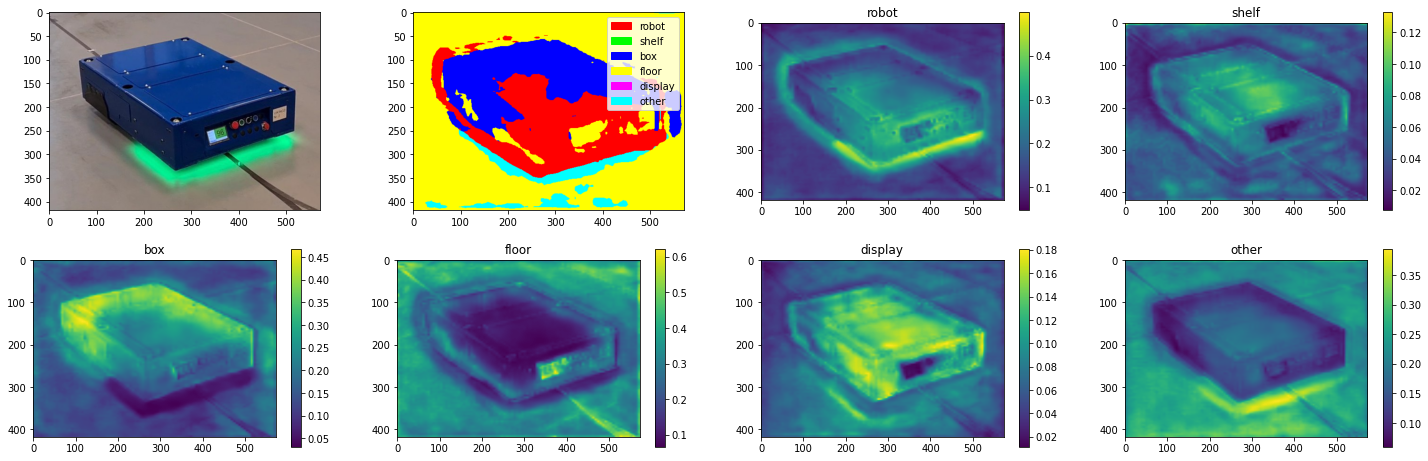

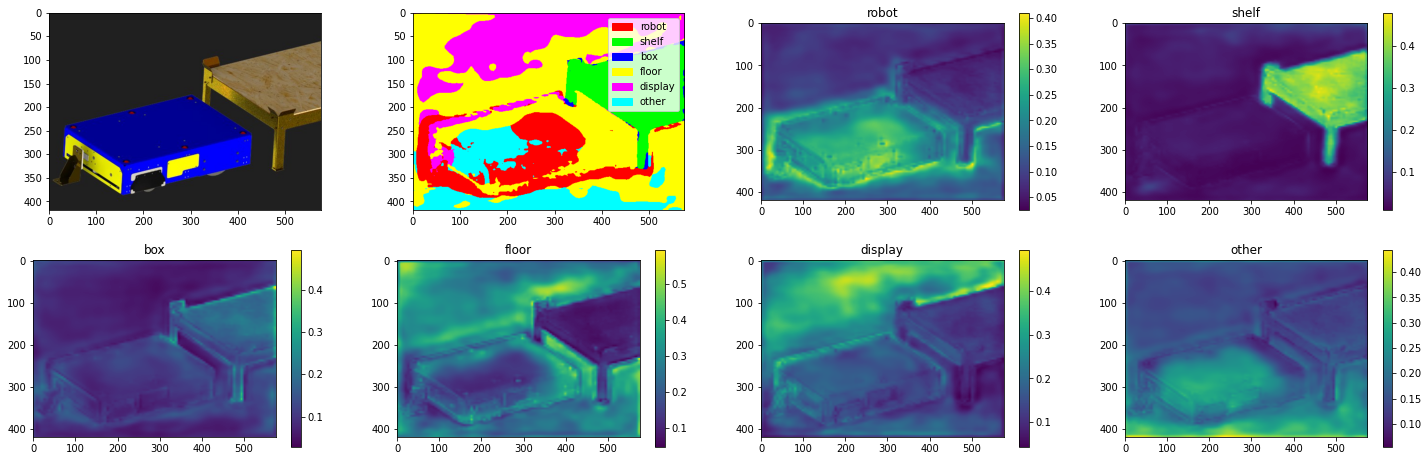

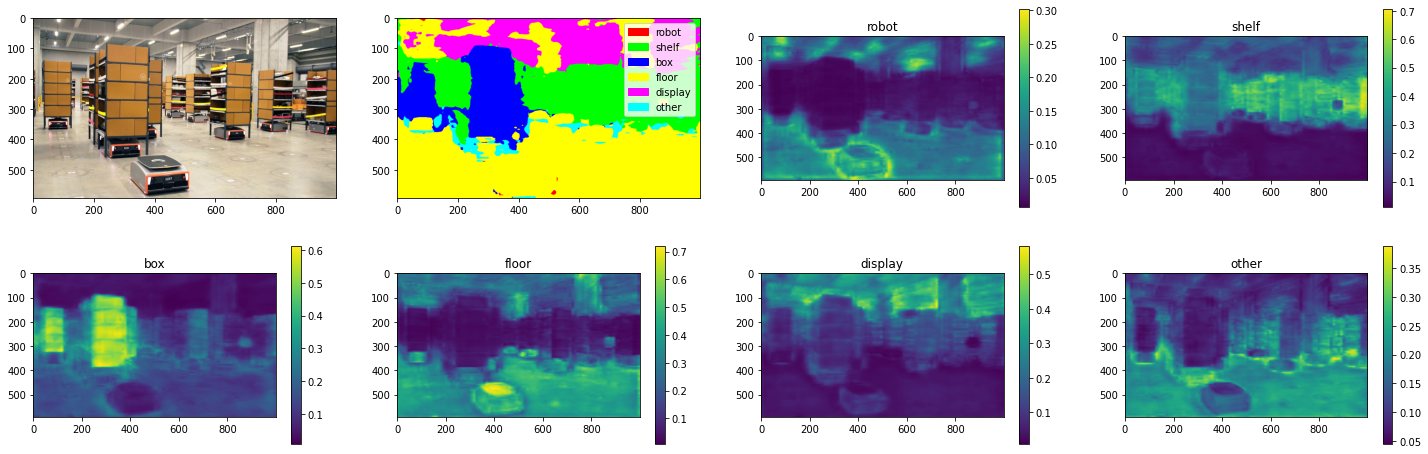

In [173]:
from tensorconversions import tnp
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
image_embr = embedders.M2FImageEmbedder()
text_embr = embedders.CLIPTextEmbedder()
smodel = segmodel.CSModel(image_embr, text_embr, model)
labels = ['robot', 'shelf', 'box', 'floor', 'display', 'other']
for i in range(1, 5):
    path = './RoboPhoto/' + str(i) + '.jpg'
    img = imageops.open_image(path)
    hmaps = smodel.forward(img, labels)
    plt.figure(figsize = (25, 8))
    plt.subplot(2, (len(labels) + 2 + 1) // 2, 1)
    plt.imshow(img)
    plt.subplot(2, (len(labels) + 2 + 1) // 2, 2)
    plt.imshow(array_to_rgb(hmaps))
    legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colorsl[:len(labels)], labels)]
    plt.legend(handles=legend_patches)
    for idx, l in enumerate(labels):
        plt.subplot(2, (len(labels) + 2 + 1) // 2, idx + 3)
        plt.imshow(hmaps[idx])
        plt.colorbar()
        plt.title(l)
    plt.savefig('./RoboPhoto/' + str(i) + 'output' + '.png', bbox_inches = 'tight')

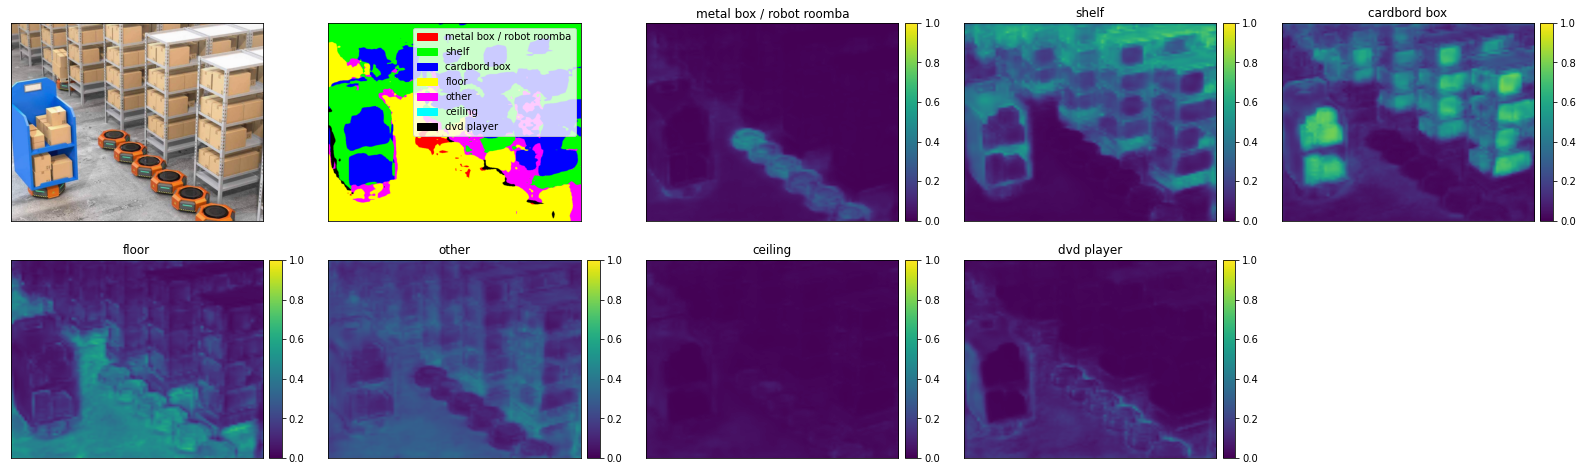

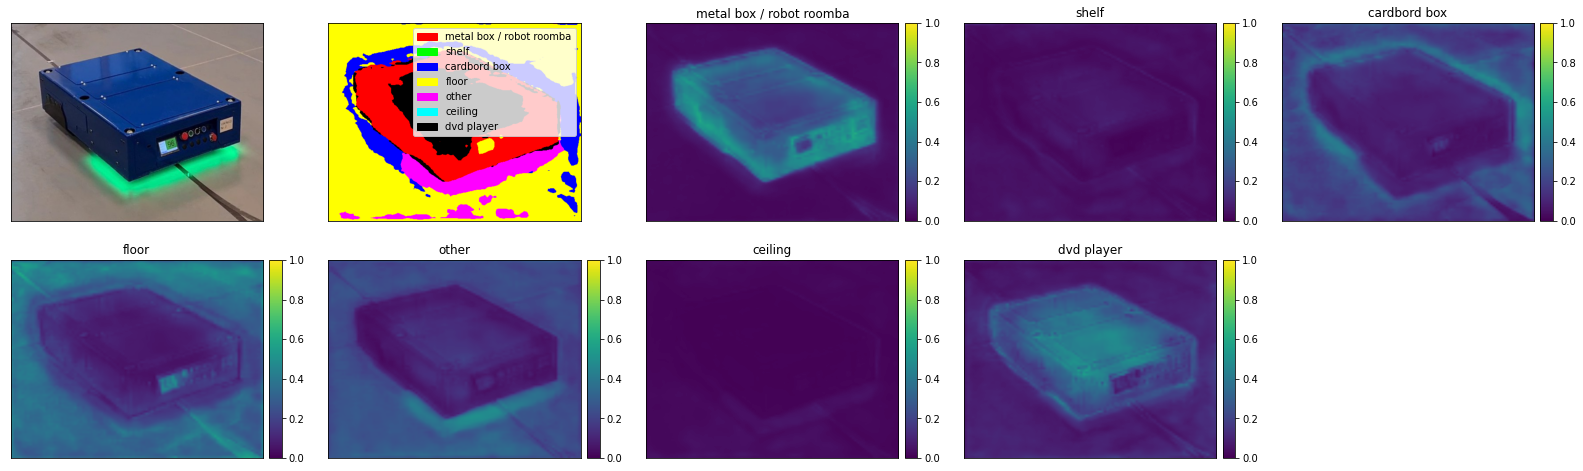

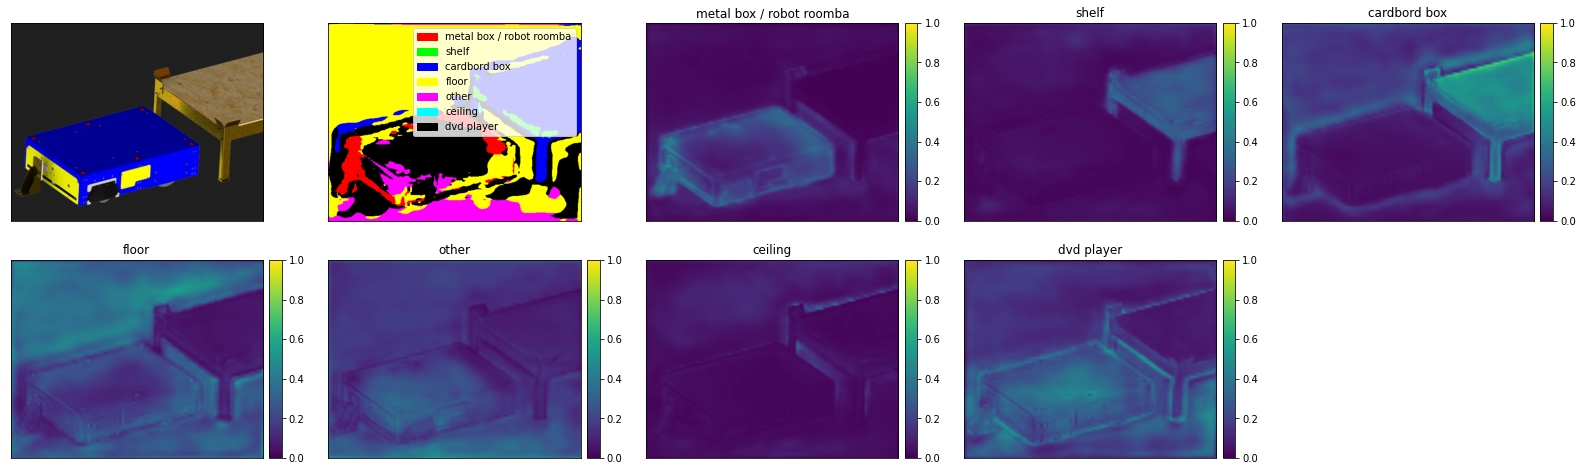

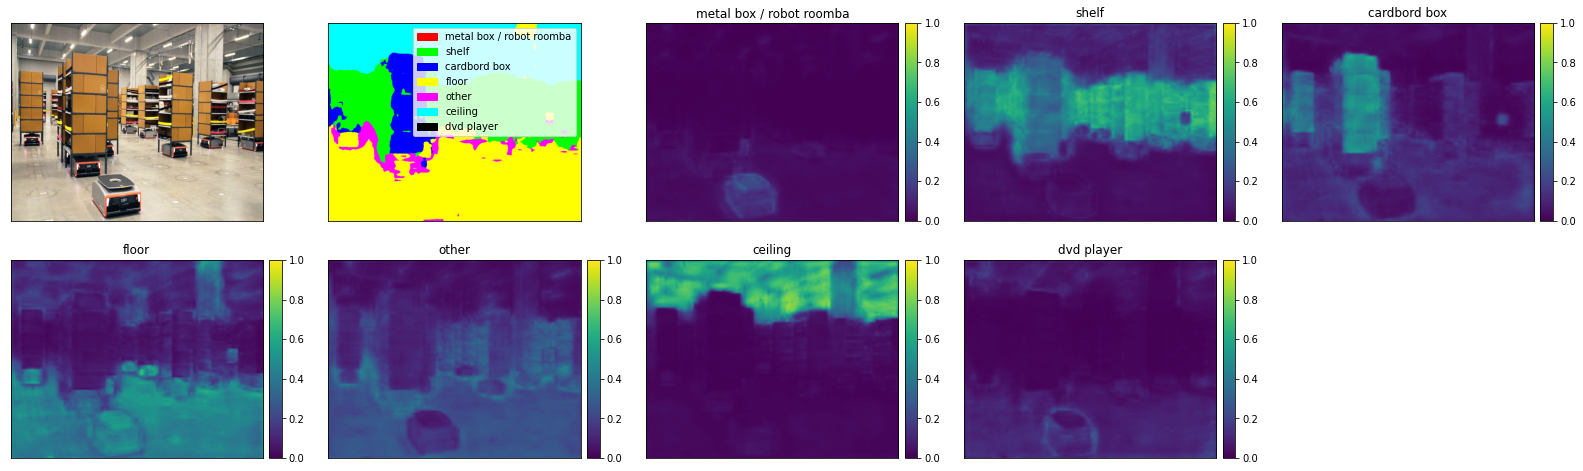

In [227]:
from matplotlib import gridspec
from tensorconversions import tnp
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
image_embr = embedders.M2FImageEmbedder()
text_embr = embedders.CLIPTextEmbedder()
smodel = segmodel.CSModel(image_embr, text_embr, model)
labels = ['metal box / robot roomba', 'shelf', 'cardbord box', 'floor', 'other', 'ceiling', 'dvd player']

# For each image
for i in range(1, 5):
    path = './RoboPhoto/' + str(i) + '.jpg'
    img = imageops.open_image(path)
    hmaps = smodel.forward(img, labels)

    fig = plt.figure(figsize=(28, 8))
    
    # Define the GridSpec
    width = ((len(labels) + 2 + 1) // 2) * 2
    gs = gridspec.GridSpec(2, width, width_ratios=[1, 0.05]*(width // 2))
    
    # Original image
    ax0 = fig.add_subplot(gs[0, 0])
    ax0.imshow(img, aspect = 'auto')
    ax0.set_xticks([])
    ax0.set_yticks([])

    # RGB Heatmaps
    ax1 = fig.add_subplot(gs[0, 2])
    ax1.imshow(array_to_rgb(hmaps), aspect = 'auto')
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colorsl[:len(labels)], labels)]
    ax1.legend(handles=legend_patches)

    # Individual heatmaps and their colorbars
    for idx, l in enumerate(labels):
        ax = fig.add_subplot(gs[(idx * 2 + 4) // width, (idx*2 + 4) % width])
        cax = fig.add_subplot(gs[(idx * 2 + 5) // width, (idx*2 + 5) % width])
        pos = cax.get_position()
        new_pos = [pos.x0 - 0.01, pos.y0, pos.width, pos.height]
        cax.set_position(new_pos)
        ax.set_xticks([])
        ax.set_yticks([])
        
        im = ax.imshow(hmaps[idx], aspect = 'auto', vmin = 0, vmax = 1)
        plt.colorbar(im, cax=cax, pad = 0)
        ax.set_title(l)

    plt.savefig(f'./RoboPhoto/{i}output.png', bbox_inches='tight')


In [41]:
image_embr = embedders.M2FImageEmbedder()
text_embr = embedders.CLIPTextEmbedder()

ds = immaskdataset.RUGDDataset()

test_embeddings = []
test_masks = []
test_count = 3000

train_embeddings = []
train_masks = []
train_count = 500

print("I loaded everything")

import gc
gc.collect()

labels = ds.labels
label_emb = text_embr.forward(labels)

print("I got to the testing samples")
for i in range(test_count):
    image, masks = ds.get_next()
    #test_embeddings.append(image_embr.forward(image))
    #test_masks.append(torch.tensor(masks, requires_grad = False, device = defdevice.def_device))
    if i % 100 == 0:
        print(i)

print("I got to the training samples")
for i in range(train_count):
    for j in range(5):
        image, masks = ds.get_next()
    image, masks = ds.get_next()
    train_embeddings.append(image_embr.forward(image))
    train_masks.append(torch.tensor(masks, requires_grad = False, device = defdevice.def_device))
    if i % 10 == 0:
        print(i)
    
test_embeddings = torch.tensor(test_embeddings, requires_grad = False, device = defdevice.def_device)
train_embeddings = torch.tensor(train_embeddings, requires_grad = False, device = defdevice.def_device)

I loaded everything
I got to the testing samples
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
I got to the training samples
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490


In [42]:
label_emb = torch.tensor(label_emb)

In [43]:
import torch.nn.functional as F

optim = torch.optim.Adam(model.parameters, lr = 0.003)

epoch_count = 10

for j in range(epoch_count):
    for i in range(train_count):
        trans_embs = model.forward(label_emb)

        prods = torch.einsum('eyx,ne->nyx', train_embeddings[i], trans_embs)
        probs = torch.softmax(prods, dim = 0)

        batch_size, y, x = masks.shape

        probs_interpolated = F.interpolate(probs.unsqueeze(1), size=(y, x), mode='bilinear', align_corners=False)

        probs_interpolated = probs_interpolated.squeeze(1)
        
        loss = ((probs_interpolated - train_masks[i]) ** 2).mean()
        
        loss.backward()
        optim.step()
        optim.zero_grad()
        
    print(loss)

tensor(0.0064, grad_fn=<MeanBackward0>)
tensor(0.0063, grad_fn=<MeanBackward0>)
tensor(0.0063, grad_fn=<MeanBackward0>)
tensor(0.0063, grad_fn=<MeanBackward0>)
tensor(0.0063, grad_fn=<MeanBackward0>)
tensor(0.0063, grad_fn=<MeanBackward0>)
tensor(0.0063, grad_fn=<MeanBackward0>)
tensor(0.0063, grad_fn=<MeanBackward0>)
tensor(0.0063, grad_fn=<MeanBackward0>)
tensor(0.0063, grad_fn=<MeanBackward0>)


# Testing

In [63]:
smodel = segmodel.CSModel(image_embr, text_embr, model)
ds = immaskdataset.ADEDataset()
res, dres = metrics.test_segmodel(smodel, ds, amount = 100)
print(res)

MSE over everything - 0.005630486875906768
Pixel accuracy - 0.2643039603379456
Mean recall - 0.06716856711301797
Mean precision - 0.06973818137504173
Mean IoU - 0.02549268613135512
Mean F1 - inf

Small Recall: 0.0 - 
Small Recall: 0.0 - cabinet
Small Recall: 0.0 - mountain, mount
Small Recall: 0.0 - curtain, drape, drapery, mantle, pall
Small Recall: 0.0 - shelf

Big   Recall: 0.9648890921343496 - grass
Big   Recall: 0.9420975602412491 - sky
Big   Recall: 0.8604924364667956 - building, edifice
Big   Recall: 0.8273585500073759 - tree
Big   Recall: 0.7415349845285836 - stove, kitchen stove, range, kitchen range, cooking stove

Small Precision: 0.0 - 
Small Precision: 0.0 - cabinet
Small Precision: 0.0 - mountain, mount
Small Precision: 0.0 - curtain, drape, drapery, mantle, pall
Small Precision: 0.0 - shelf

Big   Precision: 0.9999966666777778 - counter
Big   Precision: 0.8790186042511325 - bed 
Big   Precision: 0.8449214588867129 - person, individual, someone, somebody, mortal, soul
Big

In [50]:
smodel = segmodel.CSModel(image_embr, text_embr, model)

In [51]:
ds = immaskdataset.RUGD6Dataset()
res, dres = metrics.test_segmodel(smodel, ds, amount = 2000, multilabel = True)

In [52]:
print(res)

MSE over everything - 0.017238513165313312
Pixel accuracy - 0.9405004069767442
Mean recall - 0.785347181219206
Mean precision - 0.8616902973700699
Mean IoU - 0.7095360011056738
Mean F1 - 1.2617932282835798

Small Recall: 0.4020403512151257 - ['water']
Small Recall: 0.6040696281450529 - ['rock-bed', 'rock']
Small Recall: 0.8687156525789014 - ['void', 'sky', 'sign']
Small Recall: 0.9206480900578825 - ['tree', 'pole', 'vehicle', 'container/generic-object', 'building', 'log', 'bicycle', 'person', 'fence', 'bush', 'bridge', 'picnic-table']
Small Recall: 0.937236279534442 - ['asphalt', 'concrete']

Big   Recall: 0.979373085783831 - ['dirt', 'sand', 'grass', 'gravel', 'mulch']
Big   Recall: 0.937236279534442 - ['asphalt', 'concrete']
Big   Recall: 0.9206480900578825 - ['tree', 'pole', 'vehicle', 'container/generic-object', 'building', 'log', 'bicycle', 'person', 'fence', 'bush', 'bridge', 'picnic-table']
Big   Recall: 0.8687156525789014 - ['void', 'sky', 'sign']
Big   Recall: 0.60406962814505

In [26]:
ds = immaskdataset.RUGD6Dataset()
res, dres = metrics.test_segmodel(smodel, ds, amount = 100, multilabel = True)

In [27]:
print(res)

MSE over everything - 0.013648053159169364
Pixel accuracy - 0.9560590909090909
Mean recall - 0.632338245407527
Mean precision - 0.6281392198092612
Mean IoU - 0.5979937820889533
Mean F1 - inf

Small Recall: 0.0 - ['rock-bed', 'rock']
Small Recall: 0.0 - ['water']
Small Recall: 0.9285653872283952 - ['void', 'sky', 'sign']
Small Recall: 0.938350097809037 - ['asphalt', 'concrete']
Small Recall: 0.9473983294128806 - ['tree', 'pole', 'vehicle', 'container/generic-object', 'building', 'log', 'bicycle', 'person', 'fence', 'bush', 'bridge', 'picnic-table']

Big   Recall: 0.9797156579948493 - ['dirt', 'sand', 'grass', 'gravel', 'mulch']
Big   Recall: 0.9473983294128806 - ['tree', 'pole', 'vehicle', 'container/generic-object', 'building', 'log', 'bicycle', 'person', 'fence', 'bush', 'bridge', 'picnic-table']
Big   Recall: 0.938350097809037 - ['asphalt', 'concrete']
Big   Recall: 0.9285653872283952 - ['void', 'sky', 'sign']
Big   Recall: 0.0 - ['water']

Small Precision: 0.0 - ['rock-bed', 'rock']

# Same splits as GaNav

In [3]:
import misc
misc.free_ram()

1467738501120

In [4]:
model = nns.Linear(1, 1)
model.load("CSTableModel")

In [5]:
def read_file(path):
    res = []
    with open(path, 'r') as f:
        for line in f:
            res.append(line.strip())
    return res

gn_test = read_file('RUGDSamples/val_ours.txt')
gn_train = read_file('RUGDSamples/train_ours.txt')

In [6]:
importlib.reload(immaskdataset)
image_embr = embedders.M2FImageEmbedder()
text_embr = embedders.CLIPTextEmbedder()

ds = immaskdataset.CursedRUGDDataset(gn_test)

test_embeddings = []
test_masks = []
test_count = ds.sample_count

import gc
gc.collect()

labels = ds.labels
label_emb = text_embr.forward(labels)

print("I got to the testing samples")
for i in range(test_count):
    image, masks = ds.get_next()
    test_embeddings.append(image_embr.forward(image))
    test_masks.append(torch.tensor(masks, requires_grad = False, device = 'cpu'))
    if i % 100 == 0:
        print(i)

ds = immaskdataset.CursedRUGDDataset(gn_train)

train_embeddings = []
train_masks = []
train_count = ds.sample_count

print("I got to the training samples")
for i in range(train_count):
    image, masks = ds.get_next()
    train_embeddings.append(image_embr.forward(image))
    train_masks.append(torch.tensor(masks, requires_grad = False, device = 'cpu'))
    if i % 100 == 0:
        print(i)
    
test_embeddings = torch.tensor(test_embeddings, requires_grad = False, device = 'cpu')
train_embeddings = torch.tensor(train_embeddings, requires_grad = False, device = 'cpu')

I got to the testing samples
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
I got to the training samples
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200


<ipython-input-6-bfe2ad3318e1>:39: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  test_embeddings = torch.tensor(test_embeddings, requires_grad = False, device = 'cpu')


In [7]:
import numpy as np
datanorm = [176.84899108458802,
 22.770959359515217,
 24.432081873774745,
 0.17658022637230222,
 0.10323894684094753,
 38.86568615534216,
 12.659136732173993,
 0.5165228360262227,
 6.455118772817765,
 37.383837746380074,
 2.8242188772279646,
 0.5780836244652384,
 2.793418934650187,
 0.3791969510315244,
 1.9018610446532904,
 6.454188177990181,
 857.5663530039241,
 509.06305434315567,
 5.5523635875699515,
 0.8650638720298811,
 553.3685820062638,
 36.342039392960935,
 24.287397197842797,
 6.765666635909437,
 49.155326860598315]
datanormsqrt = [20.602698834319295,
 7.392877074328869,
 7.65778305159894,
 0.6510192876201741,
 0.49778820708406574,
 9.658417857231651,
 5.512198724469148,
 1.113441961804317,
 3.936179903597564,
 9.472503238852871,
 2.6035864141388503,
 1.1779263974648468,
 2.589350593941132,
 0.9540150792196608,
 2.136545826519975,
 3.935896165930233,
 45.3687367978183,
 34.954943972100786,
 3.6505791549627764,
 1.4409433540708023,
 36.444338344675856,
 9.339582619486688,
 7.635075018439775,
 4.0297501340618656,
 10.86195789693885]
gradscaling = torch.tensor(np.array(datanorm), requires_grad = False, device = defdevice.def_device)

In [8]:
label_emb = torch.tensor(label_emb, device = defdevice.def_device)

import torch.nn.functional as F

optim = torch.optim.Adam(model.parameters, lr = 0.0003)

epoch_count = 100

for j in range(epoch_count):
    dataperm = np.random.permutation(train_count)
    for i in range(train_count):
        trans_embs = model.forward(label_emb)

        iemb = train_embeddings[dataperm[i]].to(defdevice.def_device)
        iemb = iemb + torch.rand_like(iemb) * 0.002
        prods = torch.einsum('eyx,ne->nyx', iemb, trans_embs)
        probs = torch.softmax(prods, dim = 0)

        batch_size, y, x = masks.shape

        probs_interpolated = F.interpolate(probs.unsqueeze(1), size=(y, x), mode='bilinear', align_corners=False)

        probs_interpolated = probs_interpolated.squeeze(1)
        
        loss = (((probs_interpolated - train_masks[dataperm[i]].to(defdevice.def_device)) ** 2) * gradscaling.reshape([-1, 1, 1])).mean()
        
        loss.backward()
        optim.step()
        optim.zero_grad()
        
    print('Epoch', j, loss)

Epoch 0 tensor(0.0021, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 1 tensor(0.0071, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 2 tensor(0.0037, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 3 tensor(0.0320, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 4 tensor(0.0137, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 5 tensor(0.0078, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 6 tensor(0.0099, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 7 tensor(0.0094, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 8 tensor(0.0523, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 9 tensor(0.0278, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 10 tensor(0.0010, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 11 tensor(0.0040, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 12 tensor(0.0125, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 13 tensor(0.0031, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 14 tensor(0.2152, dtype=

In [9]:
import latexstuff

smodel = segmodel.CSModel(image_embr, text_embr, model)
gn_val = read_file('RUGDSamples/val_ours.txt')
ds = immaskdataset.CursedRUGD6Dataset(gn_val)
res, dres = metrics.test_segmodel(smodel, ds, amount = ds.sample_count, multilabel = True, aggregation = 'max')

def extract(x):
     return np.round(np.array([x['Accuracy'], x['Recall Mean'], x['Precision Mean'], x['IoU Mean']]) * 1000) / 10

ours = extract(dres)
fulldata = np.stack([ours], axis = 0)
xlabels = ['Pixel Accuracy', 'Mean Recall', 'Mean Precision', 'Mean IoU']
ylabels = ['Ours']
print(latexstuff.make_table(fulldata, xlabels, ylabels))

\begin{tabular}{l|cccc}
\toprule
 & Pixel Accuracy & Mean Recall & Mean Precision & Mean IoU \\
\midrule
Ours & 92.5 & 87.1 & 87.3 & 77.4 \\
\bottomrule
\end{tabular}


In [16]:
import latexstuff

model = nns.Linear(1, 1)
model.load("CSTableModel")
smodel = segmodel.CSModel(image_embr, text_embr, model)
gn_val = read_file('RUGDSamples/val_ours.txt')
ds = immaskdataset.CursedRUGD6Dataset(gn_val)
resut, dresut = metrics.test_segmodel(smodel, ds, amount = ds.sample_count, multilabel = True, aggregation = 'max')

def extract(x):
     return np.round(np.array([x['Accuracy'], x['Recall Mean'], x['Precision Mean'], x['IoU Mean']]) * 1000) / 10

ours = extract(dresut)
fulldata = np.stack([ours], axis = 0)
xlabels = ['Pixel Accuracy', 'Mean Recall', 'Mean Precision', 'Mean IoU']
ylabels = ['Ours']
print(latexstuff.make_table(fulldata, xlabels, ylabels))

\begin{tabular}{l|cccc}
\toprule
 & Pixel Accuracy & Mean Recall & Mean Precision & Mean IoU \\
\midrule
Ours & 86.6 & 63.6 & 62.4 & 48.9 \\
\bottomrule
\end{tabular}


In [18]:
import latexstuff

model = nns.Linear(1, 1)
model.load("CSTableModel")
smodel = segmodel.CSModel(image_embr, text_embr, model)
gn_val = read_file('RUGDSamples/val_ours.txt')
ds = immaskdataset.CursedRUGDDataset(gn_val)
resut, dresut = metrics.test_segmodel(smodel, ds, amount = ds.sample_count, multilabel = False, aggregation = 'max')

def extract(x):
     return np.round(np.array([x['Accuracy'], x['Recall Mean'], x['Precision Mean'], x['IoU Mean']]) * 1000) / 10

ours = extract(dresut)
fulldata = np.stack([ours], axis = 0)
xlabels = ['Pixel Accuracy', 'Mean Recall', 'Mean Precision', 'Mean IoU']
ylabels = ['Ours']
print(latexstuff.make_table(fulldata, xlabels, ylabels))

\begin{tabular}{l|cccc}
\toprule
 & Pixel Accuracy & Mean Recall & Mean Precision & Mean IoU \\
\midrule
Ours & 70.5 & 27.3 & 29.6 & 16.6 \\
\bottomrule
\end{tabular}


In [19]:
import latexstuff

model = nns.Linear(1, 1)
model.load("CSRUGDFineTuned")
smodel = segmodel.CSModel(image_embr, text_embr, model)
gn_val = read_file('RUGDSamples/val_ours.txt')
ds = immaskdataset.CursedRUGDDataset(gn_val)
resut, dresut = metrics.test_segmodel(smodel, ds, amount = ds.sample_count, multilabel = False, aggregation = 'max')

def extract(x):
     return np.round(np.array([x['Accuracy'], x['Recall Mean'], x['Precision Mean'], x['IoU Mean']]) * 1000) / 10

ours = extract(dresut)
fulldata = np.stack([ours], axis = 0)
xlabels = ['Pixel Accuracy', 'Mean Recall', 'Mean Precision', 'Mean IoU']
ylabels = ['Ours']
print(latexstuff.make_table(fulldata, xlabels, ylabels))

\begin{tabular}{l|cccc}
\toprule
 & Pixel Accuracy & Mean Recall & Mean Precision & Mean IoU \\
\midrule
Ours & 86.5 & 54.6 & 62.7 & 44.8 \\
\bottomrule
\end{tabular}


/tf/FreshCLIPSchitzo/metrics.py:181: RuntimeWarning: divide by zero encountered in true_divide
  res = 2 / (r + p)


In [ ]:
import latexstuff

smodel = segmodel.CSModel(image_embr, text_embr, model)
gn_val = read_file('RUGDSamples/val_ours.txt')
ds = immaskdataset.CursedRUGD25Dataset(gn_val)
res25, dres25 = metrics.test_segmodel(smodel, ds, amount = ds.sample_count, multilabel = False)

def extract(x):
     return np.round(np.array([x['Accuracy'], x['Recall Mean'], x['Precision Mean'], x['IoU Mean']]) * 1000) / 10

ours = extract(dres25)
fulldata = np.stack([ours], axis = 0)
xlabels = ['Pixel Accuracy', 'Mean Recall', 'Mean Precision', 'Mean IoU']
ylabels = ['Ours']
print(latexstuff.make_table(fulldata, xlabels, ylabels))

In [120]:
smodel = segmodel.CSModel(image_embr, text_embr, model)
gn_val = read_file('RUGDSamples/val_ours.txt')
ds = immaskdataset.CursedRUGD6Dataset(gn_val)
res, dres = metrics.test_segmodel(smodel, ds, amount = ds.sample_count, multilabel = True, aggregation = 'sum')
print(res)

MSE over everything - 0.01838785168623808
Pixel accuracy - 0.9254192301482028
Mean recall - 0.8653833790498253
Mean precision - 0.8814736939778903
Mean IoU - 0.7766260313079241
Mean F1 - 1.1501481357510495

Small Recall: 0.7131986998074706 - ['water']
Small Recall: 0.8404284385120991 - ['rock-bed', 'rock']
Small Recall: 0.8660589535876236 - ['void', 'sky', 'sign']
Small Recall: 0.9036682491731227 - ['asphalt', 'concrete']
Small Recall: 0.9176273165916327 - ['tree', 'pole', 'vehicle', 'container/generic-object', 'building', 'log', 'bicycle', 'person', 'fence', 'bush', 'bridge', 'picnic-table']

Big   Recall: 0.9513186166270029 - ['dirt', 'sand', 'grass', 'gravel', 'mulch']
Big   Recall: 0.9176273165916327 - ['tree', 'pole', 'vehicle', 'container/generic-object', 'building', 'log', 'bicycle', 'person', 'fence', 'bush', 'bridge', 'picnic-table']
Big   Recall: 0.9036682491731227 - ['asphalt', 'concrete']
Big   Recall: 0.8660589535876236 - ['void', 'sky', 'sign']
Big   Recall: 0.84042843851

In [115]:
smodel = segmodel.CSModel(image_embr, text_embr, model)
gn_val = read_file('RUGDSamples/val_ours.txt')
ds = immaskdataset.CursedRUGD6Dataset(gn_val)
res, dres = metrics.test_segmodel(smodel, ds, amount = ds.sample_count, multilabel = True, aggregation = 'sum')
print(res)

MSE over everything - 0.01826170920429104
Pixel accuracy - 0.9261377783612732
Mean recall - 0.867813962770034
Mean precision - 0.8804906962149891
Mean IoU - 0.7780924350541918
Mean F1 - 1.1492112367464569

Small Recall: 0.717466830035836 - ['water']
Small Recall: 0.8415366989481698 - ['rock-bed', 'rock']
Small Recall: 0.8725619071636946 - ['void', 'sky', 'sign']
Small Recall: 0.9061932172946161 - ['asphalt', 'concrete']
Small Recall: 0.9179234230996087 - ['tree', 'pole', 'vehicle', 'container/generic-object', 'building', 'log', 'bicycle', 'person', 'fence', 'bush', 'bridge', 'picnic-table']

Big   Recall: 0.9512017000782785 - ['dirt', 'sand', 'grass', 'gravel', 'mulch']
Big   Recall: 0.9179234230996087 - ['tree', 'pole', 'vehicle', 'container/generic-object', 'building', 'log', 'bicycle', 'person', 'fence', 'bush', 'bridge', 'picnic-table']
Big   Recall: 0.9061932172946161 - ['asphalt', 'concrete']
Big   Recall: 0.8725619071636946 - ['void', 'sky', 'sign']
Big   Recall: 0.8415366989481

In [107]:
smodel = segmodel.CSModel(image_embr, text_embr, model)
gn_val = read_file('RUGDSamples/val_ours.txt')
ds = immaskdataset.CursedRUGD6Dataset(gn_val)
res, dres = metrics.test_segmodel(smodel, ds, amount = ds.sample_count, multilabel = True, aggregation = 'sum')
print(res)

MSE over everything - 0.01818160281313033
Pixel accuracy - 0.9264502080966027
Mean recall - 0.867433471999601
Mean precision - 0.8799887034491993
Mean IoU - 0.7771528039031744
Mean F1 - 1.149960266710256

Small Recall: 0.7136143229757759 - ['water']
Small Recall: 0.8453997195985995 - ['rock-bed', 'rock']
Small Recall: 0.8706215220910969 - ['void', 'sky', 'sign']
Small Recall: 0.9050340828158543 - ['asphalt', 'concrete']
Small Recall: 0.9193253912615129 - ['tree', 'pole', 'vehicle', 'container/generic-object', 'building', 'log', 'bicycle', 'person', 'fence', 'bush', 'bridge', 'picnic-table']

Big   Recall: 0.9506057932547669 - ['dirt', 'sand', 'grass', 'gravel', 'mulch']
Big   Recall: 0.9193253912615129 - ['tree', 'pole', 'vehicle', 'container/generic-object', 'building', 'log', 'bicycle', 'person', 'fence', 'bush', 'bridge', 'picnic-table']
Big   Recall: 0.9050340828158543 - ['asphalt', 'concrete']
Big   Recall: 0.8706215220910969 - ['void', 'sky', 'sign']
Big   Recall: 0.8453997195985

In [101]:
smodel = segmodel.CSModel(image_embr, text_embr, model)
gn_val = read_file('RUGDSamples/val_ours.txt')
ds = immaskdataset.CursedRUGD6Dataset(gn_val)
res, dres = metrics.test_segmodel(smodel, ds, amount = ds.sample_count, multilabel = True, aggregation = 'sum')
print(res)

MSE over everything - 0.020602085848313877
Pixel accuracy - 0.9208635537437017
Mean recall - 0.8761265339508735
Mean precision - 0.8721290915975951
Mean IoU - 0.7772716253071126
Mean F1 - 1.1488525454409266

Small Recall: 0.7310065540187027 - ['water']
Small Recall: 0.8849635577614625 - ['void', 'sky', 'sign']
Small Recall: 0.889289181352549 - ['asphalt', 'concrete']
Small Recall: 0.8940724470108797 - ['rock-bed', 'rock']
Small Recall: 0.9041963686455622 - ['tree', 'pole', 'vehicle', 'container/generic-object', 'building', 'log', 'bicycle', 'person', 'fence', 'bush', 'bridge', 'picnic-table']

Big   Recall: 0.953231094916085 - ['dirt', 'sand', 'grass', 'gravel', 'mulch']
Big   Recall: 0.9041963686455622 - ['tree', 'pole', 'vehicle', 'container/generic-object', 'building', 'log', 'bicycle', 'person', 'fence', 'bush', 'bridge', 'picnic-table']
Big   Recall: 0.8940724470108797 - ['rock-bed', 'rock']
Big   Recall: 0.889289181352549 - ['asphalt', 'concrete']
Big   Recall: 0.8849635577614625

In [95]:
smodel = segmodel.CSModel(image_embr, text_embr, model)
gn_val = read_file('RUGDSamples/val_ours.txt')
ds = immaskdataset.CursedRUGD6Dataset(gn_val)
res, dres = metrics.test_segmodel(smodel, ds, amount = ds.sample_count, multilabel = True)
print(res)

MSE over everything - 0.019715525051582493
Pixel accuracy - 0.9245445359174133
Mean recall - 0.8825271907873363
Mean precision - 0.8593484149540984
Mean IoU - 0.7747094437903455
Mean F1 - 1.154856052887755

Small Recall: 0.7504076303751048 - ['water']
Small Recall: 0.887181958212701 - ['rock-bed', 'rock']
Small Recall: 0.893675751805926 - ['void', 'sky', 'sign']
Small Recall: 0.9010466438123513 - ['asphalt', 'concrete']
Small Recall: 0.9093552285687665 - ['tree', 'pole', 'vehicle', 'container/generic-object', 'building', 'log', 'bicycle', 'person', 'fence', 'bush', 'bridge', 'picnic-table']

Big   Recall: 0.9534959319491686 - ['dirt', 'sand', 'grass', 'gravel', 'mulch']
Big   Recall: 0.9093552285687665 - ['tree', 'pole', 'vehicle', 'container/generic-object', 'building', 'log', 'bicycle', 'person', 'fence', 'bush', 'bridge', 'picnic-table']
Big   Recall: 0.9010466438123513 - ['asphalt', 'concrete']
Big   Recall: 0.893675751805926 - ['void', 'sky', 'sign']
Big   Recall: 0.88718195821270

In [84]:
smodel = segmodel.CSModel(image_embr, text_embr, model)
gn_val = read_file('RUGDSamples/val_ours.txt')
ds = immaskdataset.CursedRUGD6Dataset(gn_val)
res, dres = metrics.test_segmodel(smodel, ds, amount = ds.sample_count, multilabel = True)
print(res)

MSE over everything - 0.019825270920642984
Pixel accuracy - 0.926763375375185
Mean recall - 0.8819185457379778
Mean precision - 0.8345885099428022
Mean IoU - 0.7565651718712111
Mean F1 - 1.1772428710672211

Small Recall: 0.7458357755237472 - ['water']
Small Recall: 0.8782475175559072 - ['void', 'sky', 'sign']
Small Recall: 0.8895835308967858 - ['rock-bed', 'rock']
Small Recall: 0.9083607403571474 - ['asphalt', 'concrete']
Small Recall: 0.9161581538494875 - ['tree', 'pole', 'vehicle', 'container/generic-object', 'building', 'log', 'bicycle', 'person', 'fence', 'bush', 'bridge', 'picnic-table']

Big   Recall: 0.9533255562447925 - ['dirt', 'sand', 'grass', 'gravel', 'mulch']
Big   Recall: 0.9161581538494875 - ['tree', 'pole', 'vehicle', 'container/generic-object', 'building', 'log', 'bicycle', 'person', 'fence', 'bush', 'bridge', 'picnic-table']
Big   Recall: 0.9083607403571474 - ['asphalt', 'concrete']
Big   Recall: 0.8895835308967858 - ['rock-bed', 'rock']
Big   Recall: 0.87824751755590

# SAM

In [125]:
importlib.reload(embedders)
importlib.reload(immaskdataset)
image_embr = embedders.SAMImageEmbedder()
text_embr = embedders.CLIPTextEmbedder()

ds = immaskdataset.CursedRUGDDataset(gn_test)

test_embeddings = []
test_masks = []
test_count = ds.sample_count

import gc
gc.collect()

labels = ds.labels
label_emb = text_embr.forward(labels)

print("I got to the testing samples")
for i in range(test_count):
    image, masks = ds.get_next()
    test_embeddings.append(image_embr.forward(image))
    test_masks.append(torch.tensor(masks, requires_grad = False, device = 'cpu'))
    if i % 100 == 0:
        print(i)

ds = immaskdataset.CursedRUGDDataset(gn_train)

train_embeddings = []
train_masks = []
train_count = ds.sample_count

print("I got to the training samples")
for i in range(train_count):
    image, masks = ds.get_next()
    train_embeddings.append(image_embr.forward(image))
    train_masks.append(torch.tensor(masks, requires_grad = False, device = 'cpu'))
    if i % 100 == 0:
        print(i)
    
test_embeddings = torch.tensor(test_embeddings, requires_grad = False, device = 'cpu')
train_embeddings = torch.tensor(train_embeddings, requires_grad = False, device = 'cpu')

I got to the testing samples
0
100
200
300
400
500
600
700
800
I got to the training samples
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200


In [131]:
model = nns.Linear(512, 256)

In [132]:
import numpy as np
datanorm = [176.84899108458802,
 22.770959359515217,
 24.432081873774745,
 0.17658022637230222,
 0.10323894684094753,
 38.86568615534216,
 12.659136732173993,
 0.5165228360262227,
 6.455118772817765,
 37.383837746380074,
 2.8242188772279646,
 0.5780836244652384,
 2.793418934650187,
 0.3791969510315244,
 1.9018610446532904,
 6.454188177990181,
 857.5663530039241,
 509.06305434315567,
 5.5523635875699515,
 0.8650638720298811,
 553.3685820062638,
 36.342039392960935,
 24.287397197842797,
 6.765666635909437,
 49.155326860598315]
datanormsqrt = [20.602698834319295,
 7.392877074328869,
 7.65778305159894,
 0.6510192876201741,
 0.49778820708406574,
 9.658417857231651,
 5.512198724469148,
 1.113441961804317,
 3.936179903597564,
 9.472503238852871,
 2.6035864141388503,
 1.1779263974648468,
 2.589350593941132,
 0.9540150792196608,
 2.136545826519975,
 3.935896165930233,
 45.3687367978183,
 34.954943972100786,
 3.6505791549627764,
 1.4409433540708023,
 36.444338344675856,
 9.339582619486688,
 7.635075018439775,
 4.0297501340618656,
 10.86195789693885]
gradscaling = torch.tensor(np.array(datanormsqrt), requires_grad = False, device = defdevice.def_device)

In [133]:
label_emb = torch.tensor(label_emb, device = defdevice.def_device)

import torch.nn.functional as F

optim = torch.optim.Adam(model.parameters, lr = 0.0003)

epoch_count = 100

for j in range(epoch_count):
    dataperm = np.random.permutation(train_count)
    for i in range(train_count):
        trans_embs = model.forward(label_emb)

        iemb = train_embeddings[dataperm[i]].to(defdevice.def_device)
        #iemb = iemb + torch.rand_like(iemb) * 0.002
        prods = torch.einsum('eyx,ne->nyx', iemb, trans_embs)
        probs = torch.softmax(prods, dim = 0)

        batch_size, y, x = masks.shape

        probs_interpolated = F.interpolate(probs.unsqueeze(1), size=(y, x), mode='bilinear', align_corners=False)

        probs_interpolated = probs_interpolated.squeeze(1)
        
        loss = (((probs_interpolated - train_masks[dataperm[i]].to(defdevice.def_device)) ** 2) * gradscaling.reshape([-1, 1, 1])).mean()
        
        loss.backward()
        optim.step()
        optim.zero_grad()
        
    print('Epoch', j, loss)

<ipython-input-133-76d79fed012b>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_emb = torch.tensor(label_emb, device = defdevice.def_device)


Epoch 0 tensor(0.0182, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 1 tensor(0.0245, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 2 tensor(0.0146, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 3 tensor(0.0197, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 4 tensor(0.0243, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 5 tensor(0.0349, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 6 tensor(0.0340, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 7 tensor(0.0094, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 8 tensor(0.0189, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 9 tensor(0.0314, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 10 tensor(0.0129, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 11 tensor(0.0177, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 12 tensor(0.0544, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 13 tensor(0.0278, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 14 tensor(0.0135, dtype=

In [134]:
smodel = segmodel.CSModel(image_embr, text_embr, model)
gn_val = read_file('RUGDSamples/val_ours.txt')
ds = immaskdataset.CursedRUGD6Dataset(gn_val)
res, dres = metrics.test_segmodel(smodel, ds, amount = 100, multilabel = True, aggregation = 'sum')
print(res)

MSE over everything - 0.05086925798111016
Pixel accuracy - 0.807490644820296
Mean recall - 0.3579855528322032
Mean precision - 0.38711310051259024
Mean IoU - 0.28948039243019646
Mean F1 - inf

Small Recall: 0.0 - ['asphalt', 'concrete']
Small Recall: 0.0 - ['rock-bed', 'rock']
Small Recall: 0.0 - ['water']
Small Recall: 0.4735655389794914 - ['void', 'sky', 'sign']
Small Recall: 0.7810724325744884 - ['tree', 'pole', 'vehicle', 'container/generic-object', 'building', 'log', 'bicycle', 'person', 'fence', 'bush', 'bridge', 'picnic-table']

Big   Recall: 0.8932753454392391 - ['dirt', 'sand', 'grass', 'gravel', 'mulch']
Big   Recall: 0.7810724325744884 - ['tree', 'pole', 'vehicle', 'container/generic-object', 'building', 'log', 'bicycle', 'person', 'fence', 'bush', 'bridge', 'picnic-table']
Big   Recall: 0.4735655389794914 - ['void', 'sky', 'sign']
Big   Recall: 0.0 - ['water']
Big   Recall: 0.0 - ['rock-bed', 'rock']

Small Precision: 0.0 - ['asphalt', 'concrete']
Small Precision: 0.0 - ['r

In [135]:
smodel = segmodel.CSModel(image_embr, text_embr, model)
gn_val = read_file('RUGDSamples/val_ours.txt')
ds = immaskdataset.CursedRUGD6Dataset(gn_val)
res, dres = metrics.test_segmodel(smodel, ds, amount = ds.sample_count, multilabel = True, aggregation = 'sum')
print(res)

MSE over everything - 0.03947229001308904
Pixel accuracy - 0.8475591637957183
Mean recall - 0.4677522217438446
Mean precision - 0.6113621397673656
Mean IoU - 0.4059011839596791
Mean F1 - inf

Small Recall: 0.0 - ['water']
Small Recall: 0.09858781532500743 - ['asphalt', 'concrete']
Small Recall: 0.25104508138819076 - ['rock-bed', 'rock']
Small Recall: 0.675004710554917 - ['void', 'sky', 'sign']
Small Recall: 0.8325139610023394 - ['tree', 'pole', 'vehicle', 'container/generic-object', 'building', 'log', 'bicycle', 'person', 'fence', 'bush', 'bridge', 'picnic-table']

Big   Recall: 0.949361762192613 - ['dirt', 'sand', 'grass', 'gravel', 'mulch']
Big   Recall: 0.8325139610023394 - ['tree', 'pole', 'vehicle', 'container/generic-object', 'building', 'log', 'bicycle', 'person', 'fence', 'bush', 'bridge', 'picnic-table']
Big   Recall: 0.675004710554917 - ['void', 'sky', 'sign']
Big   Recall: 0.25104508138819076 - ['rock-bed', 'rock']
Big   Recall: 0.09858781532500743 - ['asphalt', 'concrete']


# Vid

In [ ]:
import defdevice
defdevice.force_device('cuda:3') # Insert the cuda device that you're using.
import metrics
import nns
import immaskdataset
import importlib
import imcapdataset
import embdataset
import embedders
import losses
import imageops
import misc
import segmodel
import torch
import numpy as np
from tensorconversions import tnp
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import gridspec
%matplotlib inline

In [59]:
colorsl = [[255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0], [255, 0, 255], [0, 255, 255], [0, 0, 0], [255, 255, 255], [128, 128, 128], [128, 0, 0], [0, 128, 0], [0, 0, 128]]
colors = np.array(colorsl)
colorsl = [[c / 255 for c in color] for color in colorsl]

def array_to_rgb(array):
    n, y, x = array.shape
    max_indices = np.argmax(array, axis=0)
    rgb_image = np.zeros((y, x, 3), dtype=np.uint8)
    for i in range(n):
        mask = max_indices == i
        rgb_image[mask] = colors[i]
        
    return rgb_image

In [78]:
image_embr = embedders.M2FImageEmbedder()
text_embr = embedders.CLIPTextEmbedder()
model = nns.Linear(1, 1)
model.load("CSTableModel")
smodel = segmodel.CSModel(image_embr, text_embr, model)

def run_image_vid(img, labels):
    hmaps = smodel.forward(img, labels)

    return hmaps


In [79]:
labels = [ 'Furniture', 'Wall / Barrier', 'floor', 'other']

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990


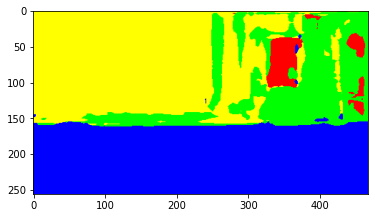

In [80]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

width, height = 468, 256
fps = 30

# Define the codec using VideoWriter_fourcc and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # or use 'XVID'
out = cv2.VideoWriter('generated_video.mp4', fourcc, fps, (width, height))


class VideoReader:
    def __init__(self, video_path):
        self.cap = cv2.VideoCapture(video_path)

    def get_frame(self):
        ret, frame = self.cap.read()
        if not ret:
            return -1
        return frame

    def release(self):
        self.cap.release()

video_path = './Vid.mp4'
video_reader = VideoReader(video_path)

hmaps = []
for i in range(2000):
    frame = video_reader.get_frame()[:256, :468]
    #There's prolly a problem with RGB BGR.
    hmaps.append(run_image_vid(frame, labels))
    if len(hmaps) > 5:
        hmaps = hmaps[1:]
    avg = np.array(hmaps).mean(axis = 0)
    res_frame = array_to_rgb(avg)
    out.write(res_frame // 2 + frame // 2)
    if i % 10 == 0:
        print(i)
        plt.imshow(res_frame)

video_reader.release()

out.release()
